# Optimisation : Placer la plus grande maison possible dans un terrain

- La maison est un rectangle
- Le terrain est un polygone quelconque, il peut être convexe ou concave
- L'optimisation peut être faite en utilisant les algorithmes PSO, DE ou ABC

In [1]:
from sympy.geometry import Point
from sympy.geometry import Polygon as SimpyPolygon
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pyclipper
import functools

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Class and converting functions

In [2]:
class Rectangle:
    """Minimal representation of a rectangle"""
    def __init__(self, point1_x, point1_y, point2_x, point2_y, longueur):
        self.point1_x = point1_x
        self.point1_y = point1_y
        self.point2_x = point2_x
        self.point2_y = point2_y
        self.longueur = longueur

In [3]:
def sol_to_rect(solution):
    """Convert a minimal rectangle to a SimpyPolygon rectangle"""
    if type(solution) != Rectangle:
        solution = Rectangle(*solution)
    point1 = Point(solution.point1_x, solution.point1_y)
    point2 = Point(solution.point2_x, solution.point2_y)
    if point1.equals(point2):
        raise ValueError("Point 1 and point 2 are the same")
    if solution.longueur == 0:
        raise ValueError("Longueur nulle interdite")
    longueur = solution.longueur
    vect = (point2.x - point1.x, point2.y - point1.y)
    distance = point1.distance(point2)
    vectUnitaire = (vect[0] / distance * longueur, vect[1] / distance * longueur)
    normalVect = (-vectUnitaire[1], vectUnitaire[0])
    point3 = Point(point2.x + normalVect[0], point2.y + normalVect[1])
    point4 = Point(point1.x + normalVect[0], point1.y + normalVect[1])
    return SimpyPolygon(point1, point2, point3, point4)

In [4]:
def path_to_polygon(path):
    """Return a polygon if it is not one yet"""
    if type(path) == list:
        return SimpyPolygon(*path)
    return path

def polygon_to_path(polygon):
    """Return a path if it is not one yet"""
    if type(polygon) == SimpyPolygon:
        return list(map(lambda p: [p.x, p.y], polygon.vertices))
    return polygon

## Drawing functions

In [5]:
def draw_polygon(polygon, ax=None, color="green"):
    """Draw a polygon over an axis (not shown directly)
    
    @param polygon: Whether a polygon or a path
    """
    if ax is None:
        ax = plt.gca()
    if type(polygon) == SimpyPolygon:
        polygon = np.array(list(map(lambda p: [p.x, p.y], polygon.vertices)))
    p = Polygon(polygon, closed=False, color=color, alpha=0.3)
    ax.add_patch(p)
    ax.axis('equal')
    return ax

In [6]:
def draw_polygons(polygons, colors=None, verbose=False):
    """Draw polygons and print the figure
    
    @param polygons: SimpyPolygon or list(SimpyPolygon)
    @param colors: colors to match to the polygons
    """
    ax = plt.gca()
    if type(polygons) == SimpyPolygon:
        polygons = [polygons]
    if colors is None:
        colors = ["grey"]*len(polygons)
    colors.reverse()
    
    for polygon in polygons:
        color = colors.pop()
        if verbose:
            print(color, "Polygon : ", polygon)
        ax = draw_polygon(polygon, ax, color=color)
    plt.show()

## Calculate the area of a polygon

In [7]:
def area(polygon):
    try:
        if type(polygon) == SimpyPolygon:
            return abs(polygon.area)
        print("In area : ", polygon)
        print("In area : ", abs(float((sol_to_rect(polygon)).area)))
        return abs(float((sol_to_rect(polygon)).area))
    except:
        printmd("### Error !")
        print(polygon)

def get_bornage_search_field(polygon):
    polygon = polygon_to_path(polygon)
    min_func = lambda acc, vertice: min(min(*vertice),acc)
    max_func = lambda acc, vertice: max(max(*vertice),acc)
    
    min_search_field = functools.reduce(min_func, polygon, sys.maxsize)
    max_search_field = functools.reduce(max_func, polygon, -sys.maxsize)
    
    return min_search_field, max_search_field
    

## Calculate the validity of a solution

In [8]:
def vertice_in_polygon(vertice, polygon):
    """ Determine if the vertice is in the polygon
    Not a strict check because of the pyclipper library in which
    the coordinates are floored.
    """
    return list(map(lambda c: int(c), vertice)) in polygon

def est_valide(rectangle, polygon):
    """ Determine if the rectangle is in the polygon
    
    @param rectangle: whether a polygon or a list of vertices
    @param polygon: whether a polygon or a list of vertices
    """
    try:
        rectangle, polygon = polygon_to_path(rectangle), polygon_to_path(polygon)
        pc = pyclipper.Pyclipper()
        pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
        pc.AddPath(rectangle, pyclipper.PT_CLIP, True)
    
        intersections = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
        
        res = (intersections != []) and (len(intersections[0]) == len(rectangle)) and np.all([vertice_in_polygon(v, intersections[0]) for v in rectangle]) 
        return res, intersections
    except pyclipper.ClipperException:
        print("Clipper exception")
        return False

House : Polygon(Point2D(12, 66), Point2D(38, 37), Point2D(1334*sqrt(1517)/1517 + 38, 1196*sqrt(1517)/1517 + 37), Point2D(12 + 1334*sqrt(1517)/1517, 1196*sqrt(1517)/1517 + 66))
Land : Polygon(Point2D(0, 0), Point2D(0, 100), Point2D(100, 100), Point2D(110, 50), Point2D(100, 0))


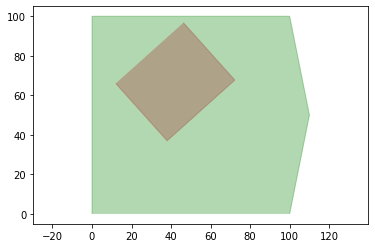

### Validité : C'est bon ça passe

### L'aire de la maison est de **1791** m² sur 10500 m² possible



green Polygon :  Polygon(Point2D(0, 0), Point2D(0, 100), Point2D(100, 100), Point2D(110, 50), Point2D(100, 0))
brown Polygon :  Polygon(Point2D(12, 66), Point2D(38, 37), Point2D(1334*sqrt(1517)/1517 + 38, 1196*sqrt(1517)/1517 + 37), Point2D(12 + 1334*sqrt(1517)/1517, 1196*sqrt(1517)/1517 + 66))
blue Polygon :  [[72, 67], [46, 96], [12, 66], [38, 37]]


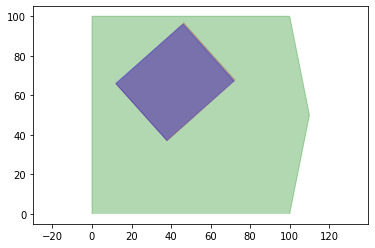

In [9]:
solution = Rectangle(*[12, 66, 38, 37, 46])
house = sol_to_rect(solution)
print("House :", house)

land = SimpyPolygon((0,0), (0,100), (100,100), (110, 50), (100, 0))
print("Land :", land)

# draw the situation
draw_polygons([land, house], colors=["green", "brown"], verbose=False)

# determine if the house is well placed over the land
res, clip = est_valide(house, land)
printmd("### Validité : C'est bon ça passe" if res else "### Validité : Noooooooon, construction incorrecte")
printmd(f"### L'aire de la maison est de **{int(area(house))}** m² sur {area(land)} m² possible\n\n")

# draw the solution to verify it is correct
draw_polygons([land, house, clip[0]], colors=["green","brown","blue"], verbose=True)

In [10]:
from ipynb.fs.full.PSO import fit as PSO_fit

In [11]:
get_bornage_search_field(land)

(0, 110)

In [12]:
def polygon_bornage(sol, land_polygon):
    rect = sol_to_rect(sol)
    if est_valide(rect, land_polygon):
        return sol 
    else:
        raise ValueError("Solution invalide par contrainte de bornage")

  0%|          | 0/3 [00:00<?, ?it/s]

In area :  [18.406384728234855, 22.98866657378805, 75.99572629168767, 79.35343287998107, 110.1864592247068]
In area :  8879.086564740232
In area :  [15.406224260675728, 20.531192599236295, 51.886373301871764, 54.03390120784465, 125.01890171511428]
In area :  6192.20116757649
In area :  [2.410492083241329, 25.377122980015464, 96.16338832552051, 81.34018220097909, 95.2023864430271]
In area :  10394.718482552737
In area :  [20.558019861633284, 28.689207907510863, 93.06510223603414, 56.56567633865104, 127.80709808441496]
In area :  9928.213398254546
In area :  [33.047018488472574, 11.303299562666341, 78.52062739815001, 104.99658547740744, 58.9674569048164]
In area :  6141.194083444723
In area :  [40.525545549427896, 27.919810535909022, 72.19783652350426, 89.33376729434244, 105.27284143852884]
In area :  7274.3518962992275
In area :  [-25.97389266067548, 25.128665284743356, 98.11597292672802, 76.08804711271762, 75.19967564888005]
In area :  10087.736816863548
In area :  [46.47936524477325, 

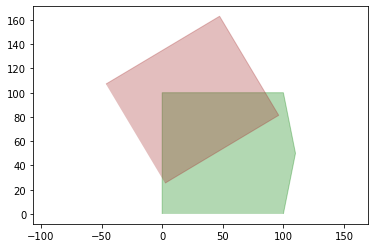

 33%|███▎      | 1/3 [00:08<00:17,  8.62s/it]

In area :  [8.731111609557518, 37.3642477962146, 34.17837794553117, 68.65984991257768, 8.182451605885177]
In area :  330.04586477873346
In area :  [54.25592070342417, 57.03984404206942, 46.15017779125688, 56.07608147740595, 190.97426063345904]
In area :  1558.8917437919993
In area :  [45.38582020401543, 43.602280246470144, -17.87266649070871, 75.39279495836037, 4.112479016501567]
In area :  291.152854388058
In area :  [15.725013700490642, 64.34332922915752, 0.4488645040260195, 72.45889541886132, 57.142350290789366]
In area :  988.4522483240071
In area :  [81.3546865902655, 102.43513726045208, 40.753843377570064, 140.2540484488111, -3.3514314399478593]
In area :  185.957594853599
In area :  [46.53310722969595, 99.45899278228663, 0.42951248424674304, 96.1380198728233, 117.00301194752454]
In area :  5408.236018517102
In area :  [-35.39005628833448, 49.77241855743183, 36.82893009380237, 67.04774840994529, 19.00943697335218]
In area :  1411.5731332104783
In area :  [64.76248958667217, 35.43

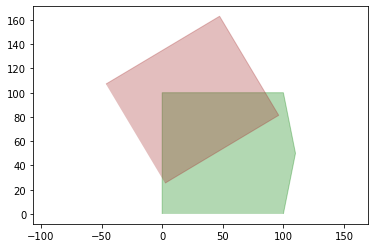

 67%|██████▋   | 2/3 [00:17<00:08,  8.66s/it]

In area :  [4.686431450583035, 27.529600750444224, 90.93238669809773, 67.39173361013354, 67.58102980303403]
In area :  6421.035223967285
In area :  [44.033142084839206, 77.26926142880313, 73.06383541409078, 67.76223961116611, -1.3340253189305997]
In area :  40.751462961172166
In area :  [-33.323985772323255, 8.495176412414203, -2.6151133609237505, 79.99098995127389, 55.95779845516776]
In area :  4354.180610039752
In area :  [14.618287071808396, 49.17851305501249, 61.35615748992314, 75.4059051265655, 82.91923087443334]
In area :  4443.96381405232
In area :  [74.8249473590258, 57.56625339016415, 23.723196179471238, 126.49749539855219, 58.71979882319867]
In area :  5038.591624429062
In area :  [2.0920683882298903, 85.46544182889427, 82.9942147007663, 87.406025901189, 54.08305989849505]
In area :  4376.694184242174
In area :  [-26.87047343339733, 63.499364595844426, 109.00102988576442, 80.39077269809724, 24.014962634349445]
In area :  3288.0671797838727
In area :  [38.56292690099782, 17.76

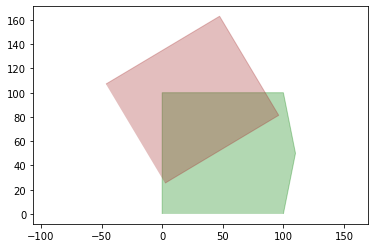

100%|██████████| 3/3 [00:26<00:00,  8.69s/it]

point = [2.410492083241329, 25.377122980015464, 96.16338832552051, 81.34018220097909, 95.2023864430271]
eval = 13.185120841399211


In [24]:
inf, sup = get_bornage_search_field(land)
PSO_fit(eval_function=area, 
        bornage_function=lambda x: polygon_bornage(x, land), 
        log_function=lambda x:draw_polygons([land, sol_to_rect(x)], colors=["green", "brown"]), 
        nb_particle=20, 
        dim=5, inf=inf, sup=sup, 
        nb_cycles=3)

In area :  [17.238688824344802, 33.826900857585485, 89.20655264720808, 43.35993743447405, 63.179434758583284]
In area :  4586.60600835587
4586.60600835587


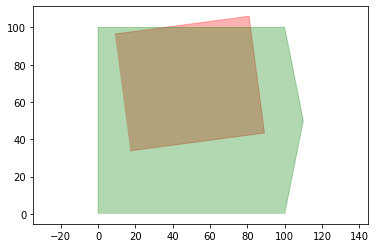

In [21]:
sol = [17.238688824344802, 33.826900857585485, 89.20655264720808, 43.35993743447405, 63.179434758583284]
print(area(sol))
draw_polygons(polygons=[sol_to_rect(sol), land], colors=["red", "green"])